# CNN intro

*This tutorial is mainly based on the excellent book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) by François Chollet as well as content from the [ML Practica](https://developers.google.com/machine-learning/practica) provided by Google Developers.*

The problem we’re trying to solve here is to classify the grayscale images of handwritten digits (28x28 pixels) into their 10 categories (0 through 9) using a convolutional neural network (CNN).

A convolutional neural network (CNN) can be used to progressively extract higher- and higher-level representations of the image content. Instead of preprocessing the data to derive features like textures and shapes, a CNN takes just the image's raw pixel data as input and "learns" how to extract these features, and ultimately infer what object they constitute (Google Developers).

## Data

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Image source: [Wikipedia, Josef Steppan](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

MNIST contains a set of 60,000 training images, plus 10,000 test images.

### Data import

The MNIST dataset comes preloaded in Keras, in the form of a set of four NumPy
arrays.

In [16]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Our training images are stored in an array:

- of shape (60000, 28, 28) 
- of type uint8 
- with values in the [0, 255] interval

In [17]:
# take a look at the shape
train_images.shape

(60000, 28, 28)

Let's take a look at our labels:

In [18]:
train_labels.shape

(60000,)

In [19]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Data preprocessing

Before training, we’ll preprocess the data:

1. `reshape()`: we reshape our training and test data. The input is samples, height, width and depth (color channel). For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray from value 0 to 255).

1. `astype()`: we transform the data into float32

1. We *scale* the data (devide by 255) so that all values are in the [0, 1] interval. 

Hence, we’ll transform our data into a float32 array of shape (60000, 28, 28, 1) with values between 0 and 1.

In [20]:
# Training data
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255

# Test data
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

## Model

Let's first address the difference between a densely connected layer and a convolution layer in Keras:

- Dense layers learn global patterns in their input feature space (for example, for a MNIST digit, patterns involving all pixels)

- convolution layers learn local patterns—in the case of images, patterns found in small 2D windows of the inputs.

### Feature maps and filters

A convolution extracts tiles of the input feature map, and applies filters to them to compute new features, producing an output feature map, or convolved feature (which may have a different size and depth than the input feature map). 

Convolutions are defined by two parameters ([Google Developers](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)):

- Size of the tiles that are extracted (typically 3x3 or 5x5 pixels).
- The depth of the output feature map, which corresponds to the number of filters that are applied.

During a convolution, the filters (matrices the same size as the tile size) effectively slide over the input feature map's grid horizontally and vertically, one pixel at a time, extracting each corresponding tile:

<br>

![](https://developers.google.com/machine-learning/practica/image-classification/images/convolution_overview.gif)

*Figure source: Google Developers*

<br>

The figure shows a 3x3 convolution of depth 1 performed over a 5x5 input feature map, also of depth 1. There are nine possible 3x3 locations to extract tiles from the 5x5 feature map, so this convolution produces a 3x3 output feature map.

In summary, convolutions operate over rank-3 tensors called **feature maps**, with two spatial axes (height and width) as well as a depth axis (also called the channels axis):

- feature map = (height, width, depth) *depth stands for color input*

For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. For a black-and-white picture, like the MNIST digits, the depth is 1 (levels of gray).

The convolution operation extracts patches from its input feature map and applies the same transformation to all of these patches, producing an **output feature map**. 

- output feature map = (height, width, depth) *depth stands for filter* 

This output feature map is still a rank-3 tensor: it has a width and a height. Its depth can be arbitrary, because the output depth is a *parameter of the layer*, and the different channels in that depth axis no longer stand for specific colors as in RGB input; rather, they stand for filters. 


**Filters** encode specific aspects of the input data: at a high level, a single filter could encode the concept “presence of a face in the input,” for instance. 

For each filter-tile pair, the CNN performs element-wise multiplication of the filter matrix and the tile matrix, and then sums all the elements of the resulting matrix to get a single value. Each of these resulting values for every filter-tile pair is then output in the convolved feature matrix (see figures).

<br>

![](https://developers.google.com/machine-learning/practica/image-classification/images/convolution_example.svg)

Figure source: Google Developers. Left: A 5x5 input feature map (depth 1). Right: a 3x3 convolution (depth 1).

<br>

![](../_static/img/feature-map.png)

Figure source: Goolge Developers. Left: The 3x3 convolution is performed on the 5x5 input feature map. Right: the resulting convolved feature. Click on a value in the output feature map to see how it was calculated.

<br>

During training, the CNN "learns" the optimal values for the filter matrices that enable it to extract meaningful features (textures, edges, shapes) from the input feature map. As the number of filters (output feature map depth) applied to the input increases, so does the number of features the CNN can extract. However, the tradeoff is that filters compose the majority of resources expended by the CNN, so training time also increases as more filters are added. Additionally, each filter added to the network provides less incremental value than the previous one, so engineers aim to construct networks that use the minimum number of filters needed to extract the features necessary for accurate image classification. (Google Developers)

### Pooling

Pooling downsamples the convolved feature (to save on processing time), reducing the number of dimensions of the feature map, while still preserving the most critical feature information. A common algorithm used for this process is called max pooling (Google Developers):

- Max pooling operates in a similar fashion to convolution. 
- We slide over the feature map and extract tiles of a specified size. 
- For each tile, the maximum value is output to a new feature map, and all other values are discarded. 
- Max pooling operations take two parameters:
    - Size of the max-pooling filter (typically 2x2 pixels)
    - Stride: the distance, in pixels, separating each extracted tile. Unlike with convolution, where filters slide over the feature map pixel by pixel, in max pooling, the stride determines the locations where each tile is extracted. For a 2x2 filter, a stride of 2 specifies that the max pooling operation will extract all nonoverlapping 2x2 tiles from the feature map:

<br>

![](https://developers.google.com/machine-learning/practica/image-classification/images/maxpool_animation.gif)

*Figure source: Google Developers*

<br>

Figure: Left: Max pooling performed over a 4x4 feature map with a 2x2 filter and stride of 2. Right: the output of the max pooling operation. Note the resulting feature map is now 2x2, preserving only the maximum values from each tile.


### Code

The following code shows what a basic convnet looks like (we use the Functional API). In essence, it’s a stack of Conv2D and MaxPooling2D layers. 

`Input`: the convnet takes as input tensors of shape (image_height, image_width,
image_channels), not including the batch dimension. In our case, we’ll configure the
convnet to process inputs of size (28, 28, 1), which is the format of MNIST images. 

[`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/): the first convolution layer takes an input feature map of size (28,
28, 1) and computes 32 filters over its input. 

- `kernel_size`: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions. Convolution is typically done with 3x3 windows and no stride (stride 1).
- `activation`: Following each convolution operation, the CNN applies a Rectified Linear Unit (ReLU) transformation to the convolved feature, in order to introduce nonlinearity into the model. The ReLU function, F(x) = max(0, x), returns x for all values of x > 0, and returns 0 for all values of x ≤ 0.

`MaxPooling2D`: consists of extracting windows from the input feature maps and
outputting the max value of each channel. Max pooling is usually done
with 2x2 windows and stride 2, in order to downsample the feature maps by a factor
of 2. 

After the last Conv2D layer, we end up with an output of shape (3, 3, 128): a 3x3
feature map of 128 channels. The next step is to feed this output into a densely connected
classifier: a stack of Dense layers. These classifiers process vectors, which are 1D, whereas the current output is a rank-3 tensor. To bridge the gap, we flatten the 3D outputs to 1D with a `Flatten` layer before adding the Dense layers.

Finally, we do 10-way classification, so our last layer has 10 outputs and a softmax
activation.

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)

x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 128)         7385

## Training


Because we’re doing 10-way classification with a softmax output, we’ll use the categorical crossentropy loss, and because our labels are integers, we’ll use the sparse version, `sparse_categorical_crossentropy`. 

In [24]:
model.compile(optimizer="rmsprop",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(train_images, train_labels, epochs=2, 
                    validation_data = (test_images, test_labels),
                    batch_size=64)

Epoch 1/2
938/938 [==============================] - 53s 55ms/step - loss: 0.0773 - accuracy: 0.9760 - val_loss: 0.0419 - val_accuracy: 0.9858
Epoch 2/2
938/938 [==============================] - 58s 62ms/step - loss: 0.0390 - accuracy: 0.9876 - val_loss: 0.0262 - val_accuracy: 0.9909


## Evaluation

In [27]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.3f}")

313/313 - 2s - loss: 0.0262 - accuracy: 0.9909 - 2s/epoch - 6ms/step
Test accuracy: 0.991


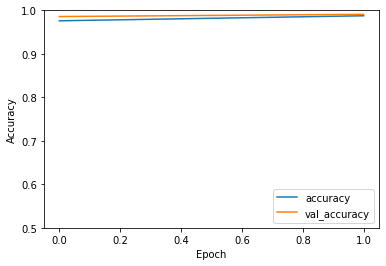

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right');
